In [1]:
%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
%%writefile dists.py
import numpy as np
from pylab import *
from scipy.stats import norm, uniform
import scipy



def error_curve(r_pos,r_neg,verticals=[],_xlim=None,_ylim=None):
    """ compute and plot the classification error curve for all rules of the form l>T
        r_pos,r_neg - arrays containing the positive ad the negative examples
        verticals - a list of pairs defining vertical lines (name,loc) loc is x location and name is a string
    """
    assert r_pos.shape[0]==r_neg.shape[0], 'r_pos and r_neg must have the same size'
    neg_data=np.stack([r_neg,ones(r_neg.shape)]).T
    pos_data=np.stack([r_pos,-ones(r_pos.shape)]).T
    data=np.concatenate([pos_data,neg_data],axis=0)

    sorted_data=data[data[:,0].argsort(),:]
    n=r_neg.shape[0]
    cs=cumsum(sorted_data[:,1])
    cs=n-cs
    min_loc=sorted_data[argmin(cs),0]
    plot([min_loc,min_loc],[0,n],label='min train error')
    for name,loc in verticals:
        plot([loc,loc],[0,n],label=name)
    plot(sorted_data[:,0],cs,label='error curve')
    xlabel('x')
    ylabel('number of mistakes')
    if not _xlim is None:
        xlim(_xlim)
    if not _ylim is None:
        ylim(_ylim)
    grid()
    legend()

class Mixture:
    """Defines pdf and sampling over mixtures of distributions"""
    def __init__(self,List):
        s=0.0
        for p,D in List:
            assert type(p) == float
            assert type(D) == scipy.stats._distn_infrastructure.rv_frozen
            s+=p
        assert abs(s-1)<10e-5
        List=sorted(List,key=lambda X:X[0])
        self.List=List
    def pdf(self,x):
        answer=np.zeros(x.shape)
        for p,D in self.List:
            answer+= p*D.pdf(x)
        return(answer)
    def rvs(self,size):
        left=size
        Samples=[]
        for p,D in self.List:
            ns = int(round(p*size))
            if(ns >left):
                ns=left
            if(ns>0):
                sample=D.rvs(size=ns)
                Samples.append(sample)
                left-=ns
        return np.concatenate(Samples)
        
def TwoNormals(_dist_from_0=1, _nsigma=3):
    x = np.linspace(-_dist_from_0-_nsigma,_dist_from_0+_nsigma,100)
    negative=norm(loc=-_dist_from_0)
    positive=norm(loc=_dist_from_0)
    plot(x, positive.pdf(x), 'b-', lw=2, label='positive')
    plot(x, negative.pdf(x), 'r-', lw=2, label='negative')
    xlabel('x')
    ylabel('density')
    grid()
    legend();
    return negative,positive


Overwriting dists.py


In [3]:
from scipy.stats import norm, uniform
import scipy

In [4]:
from dists import *

### two gaussians with similar means

means are at `-0.05,+0.05` std is 1

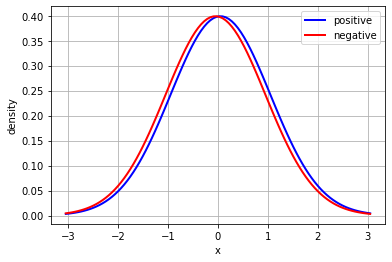

In [177]:
negative,positive=TwoNormals(_dist_from_0=0.05)

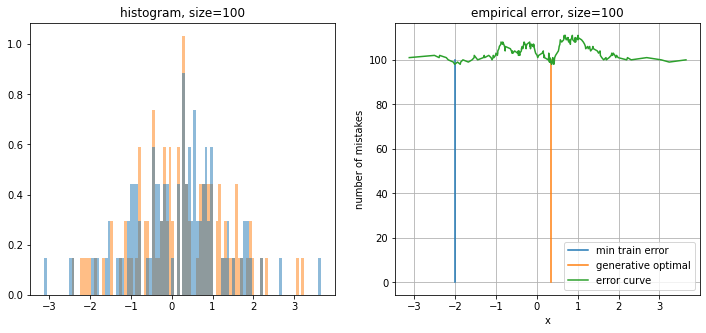

In [178]:
n=100
r_pos = positive.rvs(size=n)
r_neg = negative.rvs(size=n)

figure(figsize=[12,5])
subplot(1,2,1)
hist([r_pos,r_neg],density=True, histtype='stepfilled',bins=100, alpha=0.5);
title('histogram, size=%d'%n)
subplot(1,2,2)
thresholds_for_normals=mean(r_pos)+mean(r_neg)
error_curve(r_pos,r_neg,verticals=[('generative optimal',thresholds_for_normals)]) #_xlim=[-0.5,0.5]
title('empirical error, size=%d'%n);

### Two gaussians with different means
Means are `-4,4` std is 1


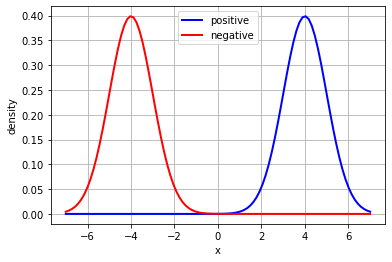

In [179]:
negative,positive=TwoNormals(_dist_from_0=4)

## generative is better than min-error
Generative is better because distribution of `pos` is a reflection of dist of `neg` while the number of samples in `[-1,1]` is too small to guide the min-error.

If we consider the whole shape of the error funcion we see that `min train error` is very unlikely to be outside of `[-4,4]`


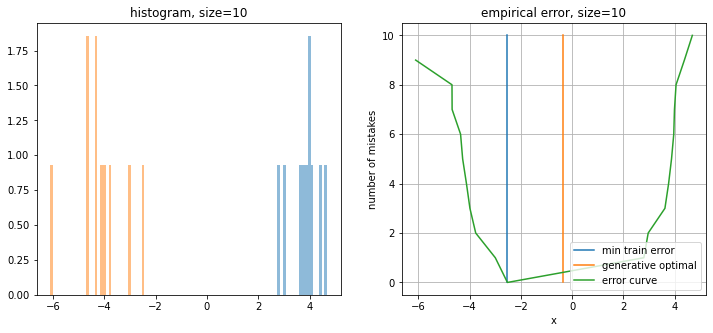

In [180]:
n=10
r_pos = positive.rvs(size=n)
r_neg = negative.rvs(size=n)

figure(figsize=[12,5])
subplot(1,2,1)
hist([r_pos,r_neg],density=True, histtype='stepfilled',bins=100, alpha=0.5);
title('histogram, size=%d'%n)
subplot(1,2,2)
thresholds_for_normals=mean(r_pos)+mean(r_neg)
error_curve(r_pos,r_neg,verticals=[('generative optimal',thresholds_for_normals)]) #_xlim=[-0.5,0.5]
title('empirical error, size=%d'%n);

### The influence of a small assymetry

We use a mixture of the well separated normals with a uniform distribution. The mixing coefficients are `[90% normal 10% uniform]`

The uniform distribution is `[60% '+', 40% '-']` from -5 to 2 and switches to `[60% '-', 40% '+']` from 2 to 9.
Therefor the best threshold is at $x=2$.

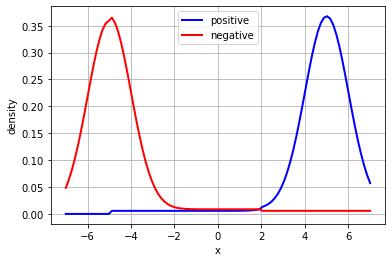

In [182]:
q=0.1
positive=Mixture([(1-q,norm(loc=5)),(0.6*q,uniform(loc=2,scale=7)),(0.4*q,uniform(loc=-5,scale=7))])
negative=Mixture([(1-q,norm(loc=-5)),(0.4*q,uniform(loc=2,scale=7)),(0.6*q,uniform(loc=-5,scale=7))])

x = np.linspace(-_dist_from_0-_nsigma,_dist_from_0+_nsigma,100)
plot(x, positive.pdf(x), 'b-', lw=2, label='positive')
plot(x, negative.pdf(x), 'r-', lw=2, label='negative')
xlabel('x')
ylabel('density')
grid()
legend();

### The assymetric case
In this case the distribution is an assymetric mixture, so even if the form of the distribution is known, it is not trivial to estimate the parameters.

The discriminative methods works well, but requires around 1000 training examples.

However even from 100 examples allow us to eliminate the thresholds outside of `[-4,4]`

Text(0.5, 1.0, 'histogram, size=100')

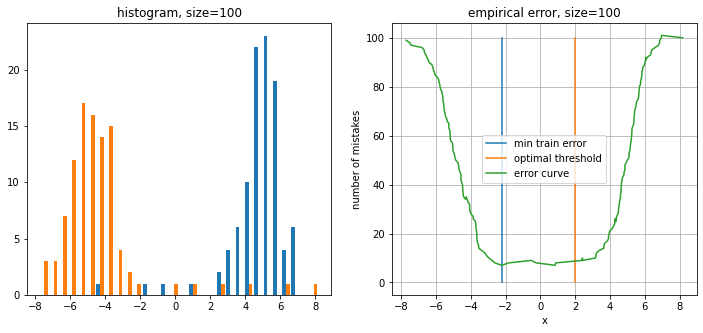

In [189]:
s=100
pos_s=pos.rvs(size=s)
neg_s=neg.rvs(size=s)

figure(figsize=[12,5])
subplot(1,2,2)
error_curve(pos_s,neg_s,verticals=[('optimal threshold',2)]);
title('empirical error, size=%d'%s)
subplot(1,2,1)
hist([pos_s,neg_s],bins=30);
title('histogram, size=%d'%s)